In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from sklearn.mixture import GaussianMixture
import os

In [3]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [5]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label


In [6]:
# chose 25 folders randomly
num_subject = 25
seed = 202311172359
chosen = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

# Load images 
images = []
labels = []

directory = Path("../ca2/data/PIE")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)

    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)

print(chosen)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


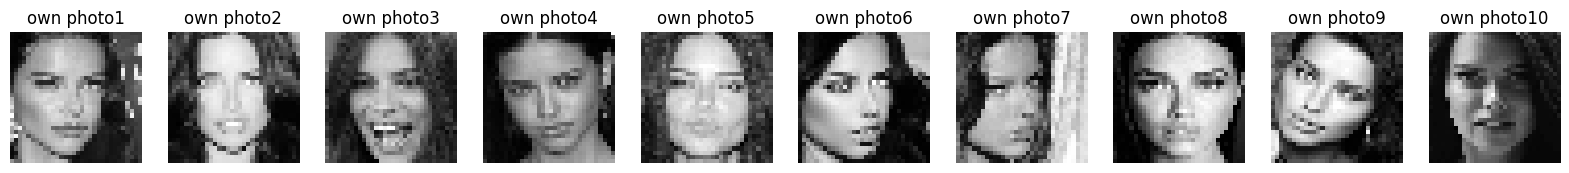

In [7]:
# process own photos
own_imgs = []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
    own_imgs.append(img)  # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69

# split training and testing data sets 
own_train_imgs = own_imgs[0:7]  # first 7 phots for training
own_test_imgs = own_imgs[7:]  # last 3 photos for testing
own_train_labels = own_labels[0:7]
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [8]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings

warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train, own_images_train, axis=0, )
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test, own_images_test, axis=0, )
full_test_labels = np.append(labels_test, own_labels_test)

In [9]:
X_train = full_train_set
y_train = full_train_labels

In [10]:
def GMM(X, d):  # X is dataset and d is dimesion of data
    gmm = GaussianMixture(n_components=3).fit(X)
    pred_y = gmm.predict(X)

    fig = plt.figure()
    ax = fig.add_subplot(8, 10, (41, 80))
    for i in range(3):
        ax.scatter(X[pred_y == i][:, 0], X[pred_y == i][:, 1], label=i, )

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.title.set_text('Clustering results for data in %d dimension' % d)
    ax.legend()

    for i in range(3):
        for j in range(10):
            faces = fig.add_subplot(8, 10, i * 10 + j + 1)
            faces.set_axis_off()
            faces.imshow(X_train[pred_y == i][j * 15].reshape(32, 32), cmap="gray")

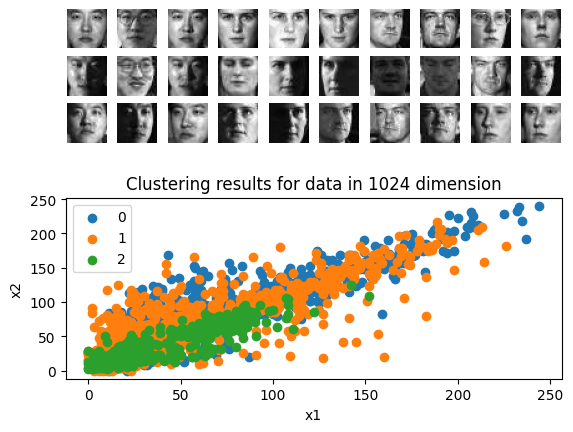

In [12]:
GMM(X_train, 32 * 32)

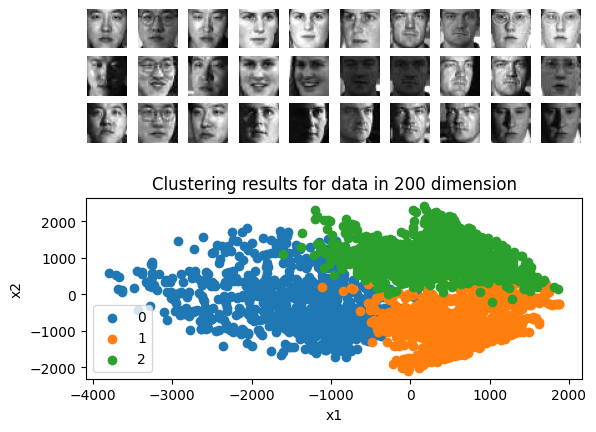

In [13]:
mean_X = np.mean(X_train, axis=0)
centered_X = X_train - mean_X

u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
s_matrix = np.diag(s)

X_pca = u[:, :200] @ s_matrix[:200, :200]

GMM(X_pca[:, :200], 200)

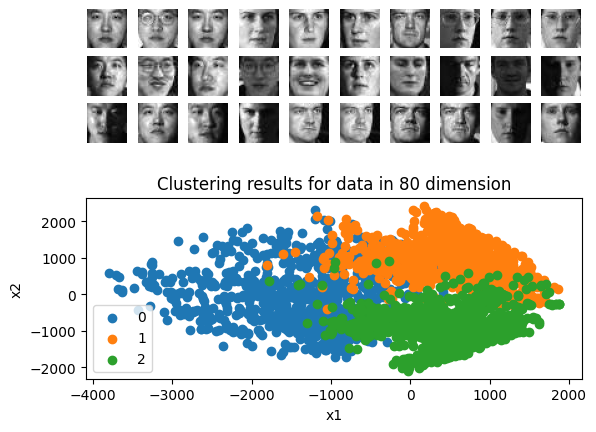

In [14]:
GMM(X_pca[:, :80], 80)